## 🚗 Driver Deactivation Policy

This notebook explores **Genetic Programming (GP)** for optimizing the **Driver Deactivation Policy** in a ride-hailing/sharing platform.

### **Policy Rules**
1. **Permanent Deactivation** occurs if a driver has committed **fraud, safety violations, or discrimination**.
2. **Temporary Deactivation** happens when a driver has a **star rating below 3** or a **cancellation rate above 80%**.
3. **No Deactivation** applies if neither condition is met.

### **Sample Data**
| ID        | Star Rating | Cancellation Rate | Fraud Acts | Safety Acts | Discrimination | Decision                   |
|-----------|------------|-------------------|------------|-------------|---------------|---------------------------|
| Driver-1  | 3          | 80%               | 0          | 0           | 0             | Temporary Deactivation    |
| Driver-2  | 4          | 10%               | 0          | 0           | 1             | Permanent Deactivation    |
| Driver-3  | 4          | 15%               | 0          | 0           | 0             | No Deactivation           |

### **Goal**
We use **Genetic Programming (GP)** to evolve a rule that best classifies driver deactivation decisions based on historical data. The policy is optimized using Genetic Programming with [DEAP (Distributed Evolutionary Algorithms in Python)](https://deap.readthedocs.io/en/master/)

### **Testing the Policy**
Once the **best policy rule** is derived using GP, we implement a function to **test new drivers** based on their attributes. The function takes inputs such as **star rating, cancellation rate, and records of fraud, safety violations, and discrimination** to determine whether the driver should be deactivated and under which category.

### Import the used libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import algorithms, base, creator, tools, gp

### Sample Data

In [2]:
data = pd.DataFrame({
    'ID': ['Driver-1', 'Driver-2', 'Driver-3'],
    'star_rating': [3, 4, 4],
    'cancellation_rate': [80, 10, 15],
    'fraud_acts': [0, 0, 0],
    'safety_acts': [0, 0, 0],
    'discrimination': [0, 1, 0],
    'decision': [1, 2, 0]  # Encoded as: 0 = No Deactivation, 1 = Temporary, 2 = Permanent
})

### Define functions for GP

In [3]:
def if_then_else(condition, out1, out2):
    return out1 if condition else out2

def greater_than(a, b):
    return int(a > b)

def not_equal(a, b):
    return int(a != b)

### Primitive Set

In [4]:
pset = gp.PrimitiveSet("MAIN", 5)  # 5 input variables
pset.addPrimitive(if_then_else, 3)
pset.addPrimitive(greater_than, 2)
pset.addPrimitive(not_equal, 2)
pset.addTerminal(0)  # No Deactivation
pset.addTerminal(1)  # Temporary Deactivation
pset.addTerminal(2)  # Permanent Deactivation

### Define the fitness function

In [5]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    func = gp.compile(expr=individual, pset=pset)
    correct = 0
    for _, row in data.iterrows():
        output = func(row['star_rating'], row['cancellation_rate'], row['fraud_acts'], row['safety_acts'], row['discrimination'])
        if output == row['decision']:
            correct += 1
    return correct / len(data),

toolbox.register("evaluate", evaluate)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)

### Run GP

gen	nevals	avg     	min	max     
0  	50    	0.326667	0  	0.666667
1  	25    	0.36    	0.333333	0.666667
2  	28    	0.373333	0       	0.666667
3  	30    	0.453333	0.333333	0.666667
4  	30    	0.533333	0.333333	0.666667
5  	35    	0.54    	0.333333	0.666667
6  	35    	0.593333	0.333333	0.666667
7  	32    	0.586667	0.333333	0.666667
8  	37    	0.626667	0.333333	0.666667
9  	29    	0.626667	0.333333	0.666667
10 	28    	0.62    	0.333333	0.666667
11 	35    	0.64    	0       	0.666667
12 	31    	0.633333	0.333333	0.666667
13 	29    	0.646667	0.333333	0.666667
14 	31    	0.62    	0       	0.666667
15 	26    	0.64    	0       	0.666667
16 	35    	0.626667	0.333333	0.666667
17 	29    	0.606667	0       	0.666667
18 	31    	0.633333	0       	0.666667
19 	29    	0.646667	0.333333	0.666667
20 	37    	0.64    	0.333333	0.666667
21 	29    	0.653333	0.333333	0.666667
22 	23    	0.653333	0.333333	0.666667
23 	29    	0.64    	0.333333	0.666667
24 	28    	0.64    	0.333333	0.666667
25 	34    	0.666667	0.

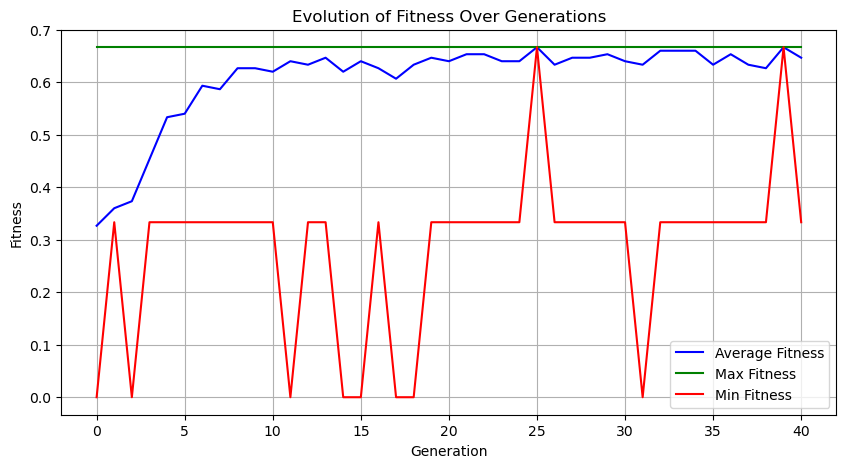

In [ ]:
def run_gp():
    population = toolbox.population(n=50)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
 
    population, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                                          stats=stats, halloffame=None, verbose=True)
    
    best_individual = tools.selBest(population, 1)[0]
    print("Best Rule Found:", best_individual)
    best_func = gp.compile(expr=best_individual, pset=pset)
    
    # Visualization
    gen = log.select("gen")
    avg_fitness = log.select("avg")
    max_fitness = log.select("max")
    min_fitness = log.select("min")
    
    plt.figure(figsize=(10, 5))
    plt.plot(gen, avg_fitness, label="Average Fitness", color='blue')
    plt.plot(gen, max_fitness, label="Max Fitness", color='green')
    plt.plot(gen, min_fitness, label="Min Fitness", color='red')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Evolution of Fitness Over Generations")
    plt.legend()
    plt.grid()
    plt.show()
    
    return best_func

best_policy = run_gp()

### Test driver policy function

In [7]:
def test_driver_policy(star_rating, cancellation_rate, fraud_acts, safety_acts, discrimination):
    decision = best_policy(star_rating, cancellation_rate, fraud_acts, safety_acts, discrimination)
    if decision == 0:
        return "No Deactivation"
    elif decision == 1:
        return "Temporary Deactivation"
    else:
        return "Permanent Deactivation"

### Example test

In [8]:
test_driver = {'star_rating': 2, 'cancellation_rate': 85, 'fraud_acts': 0, 'safety_acts': 0, 'discrimination': 0}
print("Test Driver Decision:", test_driver_policy(**test_driver))

Test Driver Decision: Temporary Deactivation
